# Expectation-Maximization Algorithm

Finally, we get to the most renowned optimizatio algorithm for HMMs: The Baum-Welch optimization/reparameterization algorithm.  Ultimately, this algorithm is an early-implemetaion of the relatively broad class of expectation-maximization algorithms.

Ultimately, the difference between the EM algorithm that we discuss here, and previous likelihood-maximizing algorithms is the definition of the 'data' that is used in the likelihood function.  Specifically, the previous likelihood function that we have maximized takes the general form $\mathcal{L}(\theta | Y^T)$ effectively taking the set of observed quantitites as the set of data for the optimization. However, another apporach considers the joint set of $Y$ *and* $X$ as the full set of data, and therefore effectively maximizes the likelihood $\mathcal{L}(\theta | X^T, Y^T)$. However, the issue is that this likelihood function can no longer be explicitly maximized, becuase we dont directly observe the hidden state sequence $X^T$.  This is why we have to use the EM algorithm (known as the Baum-Welch algorithm in the context of HMMs).

Ultimately, this algorithm is going to give us an iterative method of updating the elements of the transition ($\boldsymbol{A}$) and observation ($\boldsymbol{B}$) matrices, in such a way that they will converge towards the minimum of the so-called *Complete Data Log Likelihood* $\mathcal{L}(\theta | X^T, Y^T)$.  Here, the difficult part is inferring the elements of the transition matrix $\boldsymbol{A}$, which quantifies the transition rates between hidden states. If we were able to observe these states directly, then our best estimate of the $j\to i$ transition rate $p(x_{i, t+1} | x_{t, j})$ would be

$$ \hat{A}_{ij} =  \frac{N_{j \to i}}{N_j} $$

Which, we can restate as a probabilistic equation as

$$ \hat{A}_{ij} = \frac{\sum_t p(x_{i, t}, x_{j, t-1} | Y^T)}{\sum_t p(x_{j, t-1} | Y^T)} $$

In fact, this exact equation is what the `Maximization' (M) step of the EM algorithm is doing in this case. So our goal is then first to figure out how to calculate the unknown probability terms on teh RHS above.  First, note that the term in the denominator is just the Bayesan probabiliy estimate, which we alreay know how to calcualte useing the Bayesian smoothing algorithm. The top term, however, is more tricky to determine.

To start, note that we can use the law of total probability to split the joint probability into a product:

$$ p(x_{i, t}, x_{j, t-1} | Y^T) = p(x_{i, t} | x_{j, t-1}, Y^T) p(x_{j, t-1} | Y^T) $$

where again, the second term on the RHS is the Bayesian smoothed state estimate.

Now, to deal with the first toer on the RHS of the equation above, we first make use of Bayes rule, which states for random variables $X$ and $Y$ that

$$ P(X|Y) = \frac{P(Y|X)P(X)}{\sum_x P(Y|X)P(X)} $$

and therefore we can rewrite the above probability term as

$$ p(x_{i, t} | x_{j, t-1}, Y^T) = \frac{p(Y^T | x_{i, t}, x_{j, t-1})p(x_{i, t} | x_{j, t-1})}{\sum_{i} p(Y^T | x_{i, t}, x_{j, t-1})p(x_{i, t} | x_{j, t-1}) } $$

Now, we can splmplify this a bit by noting that $p(x_{i, t} | x_{j, t-1}) = A_{ij}$.  Next, we make use of a property of HMMs known as conditional independence of observations, given the hiden states, which effectively means that, for a sequence of three hidden states, $x_1, x_2, x_3$ and corresponding observations $y_1, y_2, y_3$, we can split a conditional joint probability as

$$ p(y_1, y_2, y_3 | x_1, x_2, x_3) = p(y_1 | x_1)p(y_2 | x_2)p(y_3 | x_3) $$

Using this logic we can rewrite the first term in the RHS numerator above as

$$
p(Y^T | x_{i, t} x_{j, t-1}) = p(Y^{[0, t-1]}, Y^{[t, T]} | x_{i, t}, x_{j, t-1})  \\
\, \\
= p(Y^{[0, t-1]} | x_{j, t-1})p(Y^{[t, T]} | x_{i, t}) \\
\, \\
= p(Y^{[0, t-1]} | x_{j, t-1})p(Y_t | x_{i,t})p(Y^{[t+1, T]} | x_{i, t}) \\
\, \\
= \alpha_{t-1}(j) B_{i, Y_t} \beta_t(j)
$$

and therefore we can rewrite our final expression for the joint probability as

$$ p(x_{i, t}, x_{j, t-1} | Y^T) = \frac{ \alpha_{t-1}(j)\beta_t(i) B_{i, y_t} A_{ij} p(x_{j, t-1} | Y^T) }{\sum_i \alpha_{t-1}(j)\beta_t(i) B_{i, y_t} A_{ij} } $$

And therefore we can estimate the terms in the $A$ matrix as

$$ \hat{A}_{ij} = \sum_t\left[\frac{\alpha_{t-1}(j)\beta_t(i) B_{i, y_t} A_{ij} p(x_{j, t-1} | Y^T) }{ \sum_i \alpha_{t-1}(j)\beta_t(i) B_{i, y_t} A_{ij} }\right] \frac{1}{\sum_t p(x_{j, t-1} | Y^T)} $$

The subtle thing here, is that in order to calcualte the terms on the RHS, we need to have an estimate already for $\boldsymbol{A}$. This is ultimately where the iterative nature of the EM algorithm enters the picture.

To start, we will go through this calculation and show how to run it using the `hidden` package before discussing the similar calcualte for the observation matrix $\boldsymbol{B}$ (which turns out to be much simpler), and then finally more on to the actual implementation of the EM algorithm.


In [1]:
import os
from pathlib import Path
import numpy as np
from hidden import dynamics, infer
from hidden.filters import bayesian

hmm = dynamics.HMM(2, 2)
hmm.init_uniform_cycle()
hmm.run_dynamics(200)

obs_ts = hmm.get_obs_ts()

analyzer = infer.MarkovInfer(2, 2)

# Now start off with an estimate of the A and B matrices that is close to the true version
A_perturb = np.array([
    [0.1, 0.05],
    [-0.1, -0.05]
])

B_perturb = np.array([
    [0.06, -0.05],
    [-0.06, 0.05]
])

A_init = hmm.A + A_perturb
B_init = hmm.B + B_perturb

In [2]:
# Now we can start the calculation.  So, for this we need the bayesian filtered
# probabilities, the alpha terms, and the beta terms

analyzer.bayesian_smooth(obs_ts, A_init, B_init)
analyzer.alpha(obs_ts, A_init, B_init, norm=True)
analyzer.beta(obs_ts, A_init, B_init, norm=True)

alpha_norm = analyzer.alpha_tracker
beta_norm = analyzer.beta_tracker
bayes = analyzer.bayes_smooth

In [3]:
# Now to get a single term (for a given time value), we can go over the
# calcualtion element-wise

# start with the 00 and 10 terms, which are for the 0 -> 0 and 1 -> 0 transitions

sample_time = 10

def get_numerator(i, j):
    return (
        A_init[i, j] * B_init[obs_ts[sample_time], i]
        * alpha_norm[sample_time - 1, j] * beta_norm[sample_time, i]
        * bayes[sample_time - 1, j]
    )

def get_denom(j):
    return (
        (
            A_init[0, j] * B_init[obs_ts[sample_time], 0]
            * alpha_norm[sample_time - 1, j] * beta_norm[sample_time, 0]
        )
        + (
            A_init[1, j] * B_init[obs_ts[sample_time], 1]
            * alpha_norm[sample_time - 1, j] * beta_norm[sample_time, 1]
        )
    )


numerator_00 = get_numerator(0, 0)
numerator_10 = get_numerator(1, 0)
numerator_01 = get_numerator(0, 1)
numerator_11 = get_numerator(1, 1)

# Now, the denominators are the same for both i values (across a column)

# Used for A_00 and A_10
denom_0 = get_denom(0)
# Used for A_01 and A_11
denom_1 = get_denom(1)

# Now, if we only had this single point in time, then we can calcualte the entries

A_00_new = (numerator_00 / denom_0) * (1 / bayes[sample_time - 1, 0])
A_10_new = (numerator_10 / denom_0) * (1 / bayes[sample_time - 1, 0])
A_01_new = (numerator_01 / denom_1) * (1 / bayes[sample_time - 1, 1])
A_11_new = (numerator_11 / denom_1) * (1 / bayes[sample_time - 1, 1])

A_new = np.array([
    [A_00_new, A_01_new],
    [A_10_new, A_11_new]
])

In [4]:
A_new

array([[0.06675758, 0.00953759],
       [0.93324242, 0.99046241]])

In [5]:
# And to see if it is still correctly normalized
A_new.sum(axis=0)

array([1., 1.])

In [40]:
# Perfect.
# So, now we can turn this into a procedure which will sum up observations over
# the entire time series of observations

# First we calculate the alpha, beta, and bayesian estimates
analyzer.bayesian_smooth(obs_ts, A_init, B_init)
analyzer.alpha(obs_ts, A_init, B_init, norm=True)
analyzer.beta(obs_ts, A_init, B_init, norm=True)

alpha_norm = analyzer.alpha_tracker
beta_norm = analyzer.beta_tracker
bayes = analyzer.bayes_smooth

# Then we calculate the numeratiors and denominators in the same manner as above
def get_numerator(i, j, sample_time):
    return (
        A_init[i, j] * B_init[i, obs_ts[sample_time]]
        * alpha_norm[sample_time - 1, j] * beta_norm[sample_time, i]
        * bayes[sample_time - 1, j]
    )

def get_denom(j, sample_time):
    return (
        (
            A_init[0, j] * B_init[0, obs_ts[sample_time]]
            * alpha_norm[sample_time - 1, j] * beta_norm[sample_time, 0]
        )
        + (
            A_init[1, j] * B_init[1, obs_ts[sample_time]]
            * alpha_norm[sample_time - 1, j] * beta_norm[sample_time, 1]
        )
    )


numer_00 = np.zeros(len(obs_ts) - 1)
numer_10 = np.zeros_like(numer_00)
numer_01 = np.zeros_like(numer_00)
numer_11 = np.zeros_like(numer_00)

denom_0 = np.zeros_like(numer_00)
denom_1 = np.zeros_like(numer_00)

for t in range(1, len(obs_ts)):
    numer_00[t-1] = get_numerator(0, 0, t)
    numer_10[t-1] = get_numerator(1, 0, t)
    numer_01[t-1] = get_numerator(0, 1, t)
    numer_11[t-1] = get_numerator(1, 1, t)

    denom_0[t-1] = get_denom(0, t)
    denom_1[t-1] = get_denom(1, t)

A_00_new = sum(numer_00 / denom_0) * (1 / sum(bayes[:-1, 0]))
A_10_new = sum(numer_10 / denom_0) * (1 / sum(bayes[:-1, 0]))
A_01_new = sum(numer_01 / denom_1) * (1 / sum(bayes[:-1, 1]))
A_11_new = sum(numer_11 / denom_1) * (1 / sum(bayes[:-1, 1]))
    
A_00_new_partial = sum(numer_00 / denom_0)
A_10_new_partial = sum(numer_10 / denom_0)
A_01_new_partial = sum(numer_01 / denom_1)
A_11_new_partial = sum(numer_11 / denom_1)

bayes_00_part = (1 / sum(bayes[:-1, 0]))
bayes_10_part = (1 / sum(bayes[:-1, 0]))
bayes_01_part = (1 / sum(bayes[:-1, 1]))
bayes_11_part = (1 / sum(bayes[:-1, 1]))

A_new = np.array([
    [A_00_new, A_01_new],
    [A_10_new, A_11_new]
])


In [7]:
bayes.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
A_new, A_new.sum(axis=0)

(array([[0.67850779, 0.35696576],
        [0.32149221, 0.64303424]]),
 array([1., 1.]))

In [21]:
# To test the vectorization of a single loop, we can check the entries in the
# matrix against single calls to the numeratir functions

sample_00 = get_numerator(0, 0, sample_time=10)
sample_10 = get_numerator(1, 0, sample_time=10)
sample_01 = get_numerator(0, 1, sample_time=10)
sample_11 = get_numerator(1, 1, sample_time=10)

sample_A_mat = np.array([
    [sample_00, sample_01],
    [sample_10, sample_11]
])

sample_time = 10

_B_mat = np.vstack([B_init[:, obs_ts[sample_time]], B_init[:, obs_ts[sample_time]]]).T
_outer_term = np.outer(beta_norm[sample_time, :], (alpha_norm[sample_time - 1, :] * bayes[sample_time - 1, :]))
sample_xi = A_init * _B_mat * _outer_term

display(sample_xi)
display(sample_A_mat)


array([[2.12068016e-06, 5.05688458e-03],
       [2.37169614e-05, 4.20118899e-01]])

array([[2.12068016e-06, 5.05688458e-03],
       [2.37169614e-05, 4.20118899e-01]])

In [22]:
# Now, we can clean this up a bit by vectorizing some of these calculations,
# specifically, we organize all of the numerators into a matrix 'xi', we cant
# really vectorize over time, but I think we can on a per-time-point basis

def get_xi_matrix(obs, A, B, alpha_norm, beta_norm, bayes):
    xi = np.zeros((2, 2, len(obs_ts) - 1))

    for t in range(1, len(obs_ts)):
        xi[:, :, t - 1] = (
            A
            * np.vstack([B[:, obs[t]], B[:, obs[t]]]).T
            * np.outer(
                beta_norm[t, :], (alpha_norm[t - 1, :] * bayes[t - 1, :])
            )
        )

    return xi

# The denominator for each element is just a column-wize normalization without
# the bayes factor, so the calcualtion is very similar
def get_denom_matrix(obs, A, B, alpha_norm, beta_norm):
    xi_denom = np.zeros((1, 2, len(obs_ts) - 1))

    for t in range(1, len(obs_ts)):
        xi_denom[:, :, t-1] = np.sum(
            A
            * np.vstack([B[:, obs[t]], B[:, obs[t]]]).T
            * np.outer(
                beta_norm[t, :], alpha_norm[t - 1, :]
            )
        , axis=0)

    # And then we sum over the columns
    xi_denom = np.vstack([xi_denom, xi_denom])

    return xi_denom

xi_num = get_xi_matrix(obs_ts, A_init, B_init, alpha_norm, beta_norm, bayes)
xi_denom = get_denom_matrix(obs_ts, A_init, B_init, alpha_norm, beta_norm)

In [23]:
xi_num.shape, xi_denom.shape

((2, 2, 199), (2, 2, 199))

In [25]:
# There will be a 1-index shift here, because t=1 corresponds to index 0 (because we have t and t-1 in each loop)
test_idx = 15

xi_num[:, :, test_idx - 1]


array([[5.19081019e-01, 1.91065595e-05],
       [2.43698698e-03, 6.66355298e-07]])

In [26]:
A_audit_00 = get_numerator(0, 0, test_idx)
A_audit_10 = get_numerator(1, 0, test_idx)
A_audit_01 = get_numerator(0, 1, test_idx)
A_audit_11 = get_numerator(1, 1, test_idx)

A_audit = np.array([
    [A_audit_00, A_audit_01],
    [A_audit_10, A_audit_11]
])
A_audit

array([[5.19081019e-01, 1.91065595e-05],
       [2.43698698e-03, 6.66355298e-07]])

In [28]:
np.isclose(A_audit, xi_num[:, :, test_idx - 1])

array([[ True,  True],
       [ True,  True]])

In [32]:
# And then also for the denominators
xi_denom[:, :, test_idx - 1]

array([[0.52474129, 0.00321898],
       [0.52474129, 0.00321898]])

In [33]:
denom_audit_0 = get_denom(0, test_idx)
denom_audit_1 = get_denom(1, test_idx)

denom_audit = np.array([
    [denom_audit_0, denom_audit_1],
    [denom_audit_0, denom_audit_1]
])
denom_audit

array([[0.52474129, 0.00321898],
       [0.52474129, 0.00321898]])

In [34]:
np.isclose(denom_audit, xi_denom[:, :, test_idx - 1])

array([[ True,  True],
       [ True,  True]])

In [35]:
# Okay, so it looks like the vectorized form is working, so now we should be
# able to do an element-wise division of these matrices, to get the series of
# numerical values for each matrix entry
ratio = np.divide(xi_num, xi_denom)
ratio.shape

(2, 2, 199)

In [37]:
# And then we just need to get the bayes matrix that we end up multiplying this
# all by
bayes_matrix = np.repeat((1 / bayes[:-1, :].sum(axis=0)).reshape(1, 2), 2, axis=0)
bayes_matrix

array([[0.00993207, 0.01017128],
       [0.00993207, 0.01017128]])

In [41]:
# So, we should now be able to calcualte the whole updated matrix by performing
# operations on the xi values

A_new_xi = np.sum(ratio, axis=2) * (bayes_matrix)
A_new_xi

array([[0.67850779, 0.35696576],
       [0.32149221, 0.64303424]])

In [39]:
A_new.sum(axis=0)

array([1., 1.])

In [42]:
# So, everything looks to be working, and we can check this against the
# explicit first pass update we have from the earler part

np.isclose(A_new, A_new_xi)

array([[ True,  True],
       [ True,  True]])

In [43]:
# So this looks like it is working, so we can patch this all tegether for a
# messy little algo to perform the updates to the A matrix

def update_A_matrix(obs_ts, analyzer: infer.MarkovInfer, A_current, B_current):
    analyzer.alpha(obs_ts, A_current, B_current, norm=True)
    analyzer.beta(obs_ts, A_current, B_current, norm=True)
    analyzer.bayesian_smooth(obs_ts, A_current, B_current)

    xi_num = get_xi_matrix(
        obs_ts, A_current, B_current,
        analyzer.alpha_tracker,
        analyzer.beta_tracker,
        analyzer.bayes_smooth
    )
    xi_denom = get_denom_matrix(
        obs_ts,
        A_current,
        B_current,
        analyzer.alpha_tracker,
        analyzer.beta_tracker
    )

    ratio = xi_num / xi_denom

    bayes_matrix = np.repeat(
        (1 / analyzer.bayes_smooth[:-1, :].sum(axis=0)).reshape(1, 2), 2,
        axis=0
    )

    new_A_matrix = np.sum(ratio, axis=2) * bayes_matrix
    return new_A_matrix

In [44]:
# And as a test to be sure this gets the same result

update_A_matrix(obs_ts, analyzer, A_init, B_init)


array([[0.67850779, 0.35696576],
       [0.32149221, 0.64303424]])

In [45]:
A_new

array([[0.67850779, 0.35696576],
       [0.32149221, 0.64303424]])

Now, with this working, we can move to how we would update the B matrix. So far we have effectively written out an implementation of the update equations for the transition matrix $\boldsymbol{A}$, but not yet for $\boldsymbol{B}$. For this, the actual update equation is relatively simple, we effectively want to calcualte terms like $p(y_{k, t}| x_{i, t})$. Probabilistically, we can write down an estimate for that value as

$$ \hat{B}_{ij} = \hat{p}(y_{i, t} | x_{j, t}) = \frac{\sum_t \delta_{y_t, i} p(x_{j, t} | Y^T ) }{\sum_t p(x_{j, t} | Y^T ) }$$

which is effectively the probability weighted number of observations of state $i$, relative to the probability of being in that state. So here, we just need the Bayesian estiamte, and to figure out how to programatically include the Kroneker-delta function

In [88]:
def _get_B_numer(i, j, obs, sample_time, bayes):
    if obs != i:
        return 0
    
    return bayes[sample_time, j]

sample_time = 15

# this is simple enough that we can probably just directly vectorize it
gamma_mat = np.zeros((2, 2, len(obs_ts)))
gamma_mat_denom = np.zeros_like(gamma_mat)

for t, obs in enumerate(obs_ts):
    gamma_mat[0, 0, t] = _get_B_numer(0, 0, obs, t, bayes)
    gamma_mat[1, 0, t] = _get_B_numer(1, 0, obs, t, bayes)
    gamma_mat[0, 1, t] = _get_B_numer(0, 1, obs, t, bayes)
    gamma_mat[1, 1, t] = _get_B_numer(1, 1, obs, t, bayes)

    gamma_mat_denom[0, 0, t] = bayes[t, 0]
    gamma_mat_denom[1, 0, t] = bayes[t, 0]
    gamma_mat_denom[0, 1, t] = bayes[t, 1]
    gamma_mat_denom[1, 1, t] = bayes[t, 1]

gamma_mat.shape, gamma_mat_denom.shape

((2, 2, 200), (2, 2, 200))

In [89]:
# gamma_mat.sum(axis=2).sum(axis=0)
gamma_mat.sum(axis=2)

array([[94.17705414,  5.82294586],
       [ 6.62913452, 93.37086548]])

In [90]:
gamma_mat_denom.sum(axis=2)
# gamma_mat_denom[:, :, 10]
# gamma_mat_denom.shape

array([[100.80618865,  99.19381135],
       [100.80618865,  99.19381135]])

In [91]:
# And then to calcuqlate the updated B matrix:

B_new_gamma = np.sum(gamma_mat, axis=2) / np.sum(gamma_mat_denom, axis=2)
B_new_gamma

array([[0.93423881, 0.05870271],
       [0.06576119, 0.94129729]])

In [92]:
B_new_gamma.sum(axis=0)

array([1., 1.])

In [120]:
bayes.T.shape

(2, 200)

In [124]:
# To clean this up more and make this routine a little more simplified, we
# can vectorize the whole think

# In-between step
def get_gamma_num(obs, t, bayes):
    _B_num = np.zeros((2, 2))

    target_row = obs
    _B_num[target_row] = bayes[t, :]    
    return _B_num

# ind_matrix = np.zeros((2, 2, len(obs_ts)))
# obs_ts_np = np.array(obs_ts)

# Indicator matrix for each observation value
# ind_matrix[0, :, obs_ts_np == 0] = 1
# ind_matrix[1, :, obs_ts_np == 1] = 1

# gamma_mat = (ind_matrix * np.hstack([bayes, bayes]).reshape(2, 2, 200)).reshape(ind_matrix.shape)
gamma_mat = np.zeros((2, 2, len(obs_ts)))
for i, obs in enumerate(obs_ts):
    gamma_mat[:, :, i] = get_gamma_num(obs, i, bayes)
gamma_denom = np.vstack([bayes.T, bayes.T]).reshape(gamma_mat.shape)

gamma_mat.sum(axis=2), gamma_denom.sum(axis=2)

(array([[94.17705414,  5.82294586],
        [ 6.62913452, 93.37086548]]),
 array([[100.80618865,  99.19381135],
        [100.80618865,  99.19381135]]))

In [125]:
gamma_denom.shape, gamma_mat.shape

((2, 2, 200), (2, 2, 200))

In [126]:
gamma_mat.sum(axis=2) / gamma_denom.sum(axis=2)

array([[0.93423881, 0.05870271],
       [0.06576119, 0.94129729]])

(array([0.00944351, 0.99055649]),
 array([[0.        , 0.        ],
        [0.95337471, 0.99266607]]))

In [127]:
# Okay, so this now works as well. So, taking all of this tegether, we can 
# write out a rough function that will perform a single iteration of the BW
# algorithm

# We will also re-declare all necessary functions that we have built so far
# in this notebook here.


def _get_gamma_numer(obs, t, bayes):
    _B_num = np.zeros((2, 2))

    target_row = obs
    _B_num[target_row] = bayes[t, :]    
    return _B_num


def get_xi_matrix(obs, A, B, alpha_norm, beta_norm, bayes):
    xi = np.zeros((2, 2, len(obs_ts) - 1))

    for t in range(1, len(obs_ts)):
        xi[:, :, t - 1] = (
            A
            * np.vstack([B[:, obs[t]], B[:, obs[t]]]).T
            * np.outer(
                beta_norm[t, :], (alpha_norm[t - 1, :] * bayes[t - 1, :])
            )
        )
    return xi


def get_denom_matrix(obs, A, B, alpha_norm, beta_norm):
    xi_denom = np.zeros((1, 2, len(obs_ts) - 1))

    for t in range(1, len(obs_ts)):
        xi_denom[:, :, t-1] = np.sum(
            A
            * np.vstack([B[:, obs[t]], B[:, obs[t]]]).T
            * np.outer(
                beta_norm[t, :], alpha_norm[t - 1, :]
            )
        , axis=0)
    # And then we sum over the columns
    xi_denom = np.vstack([xi_denom, xi_denom])

    return xi_denom


def _update_A_matrix(
    A_current, B_current, alpha_tracker, beta_tracker, bayes_smooth
):
    xi_num = get_xi_matrix(
        obs_ts, A_current, B_current, alpha_tracker, beta_tracker, bayes_smooth
    )
    xi_denom = get_denom_matrix(
        obs_ts, A_current, B_current, alpha_tracker, beta_tracker
    )

    ratio = xi_num / xi_denom

    bayes_matrix = np.repeat(
        (1 / analyzer.bayes_smooth[:-1, :].sum(axis=0)).reshape(1, 2), 2,
        axis=0
    )

    new_A_matrix = np.sum(ratio, axis=2) * bayes_matrix
    return new_A_matrix


def _update_B_matrix(obs_ts, bayes):
    gamma_mat = np.zeros((2, 2, len(obs_ts)))
    for i, obs in enumerate(obs_ts):
        gamma_mat[:, :, i] = get_gamma_num(obs, i, bayes)
    gamma_denom = np.vstack([bayes.T, bayes.T]).reshape(gamma_mat.shape)

    return (gamma_mat.sum(axis=2) / gamma_denom.sum(axis=2))


def baum_welch_step(A_current, B_current, obs_ts, analyzer):

    analyzer.alpha(obs_ts, A_current, B_current, norm=True)
    analyzer.beta(obs_ts, A_current, B_current, norm=True)
    analyzer.bayesian_smooth(obs_ts, A_current, B_current)

    A_hat = _update_A_matrix(
        A_current, B_current, analyzer.alpha_tracker, analyzer.beta_tracker,
        analyzer.bayes_smooth
    )

    B_hat = _update_B_matrix(obs_ts, analyzer.bayes_smooth)

    return A_hat, B_hat



In [132]:
# So, now we SHOULD be able to iterate through this procedure to actually
# implement the EM algorithm

A_hat = A_init
B_hat = B_init

A_tracker = [A_hat]
B_tracker = [B_hat]

for _ in range(50):
    A_hat, B_hat = baum_welch_step(A_hat, B_hat, obs_ts, analyzer)
    A_tracker.append(A_hat)
    B_tracker.append(B_hat)


In [133]:
A_final, B_final = A_tracker[-1], B_tracker[-1]

In [134]:
# MAtrices are staying normalized
A_final.sum(axis=0), B_final.sum(axis=0)

(array([1., 1.]), array([1., 1.]))

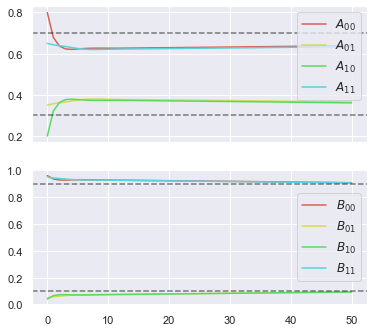

In [137]:
# And then we can also look at how parameter values change as a function of iteration
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='hls')

fig, ax = plt.subplots(2, 1, figsize=(6, 5.5), sharex=True)

ax[0].plot([A[0, 0] for A in A_tracker], label=r"$A_{00}$")
ax[0].plot([A[0, 1] for A in A_tracker], label=r"$A_{01}$")
ax[0].plot([A[1, 0] for A in A_tracker], label=r"$A_{10}$")
ax[0].plot([A[1, 1] for A in A_tracker], label=r"$A_{11}$")

ax[1].plot([B[0, 0] for B in B_tracker], label=r"$B_{00}$")
ax[1].plot([B[0, 1] for B in B_tracker], label=r"$B_{01}$")
ax[1].plot([B[1, 0] for B in B_tracker], label=r"$B_{10}$")
ax[1].plot([B[1, 1] for B in B_tracker], label=r"$B_{11}$")

ax[0].axhline(hmm.A[0,0], linestyle='--', alpha=0.5, color='k')
ax[0].axhline(hmm.A[0,1], linestyle='--', alpha=0.5, color='k')
ax[1].axhline(hmm.B[0,0], linestyle='--', alpha=0.5, color='k')
ax[1].axhline(hmm.B[0,1], linestyle='--', alpha=0.5, color='k')

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)


In [138]:
A_tracker[10], A_tracker[49]

(array([[0.62662033, 0.37850677],
        [0.37337967, 0.62149323]]),
 array([[0.63859733, 0.36589639],
        [0.36140267, 0.63410361]]))

In [139]:
# Looks like it is slowly converging, lets try to see if the convergence gets better by iterating more

In [140]:

A_hat = A_init
B_hat = B_init

A_tracker = [A_hat]
B_tracker = [B_hat]

for _ in range(500):
    A_hat, B_hat = baum_welch_step(A_hat, B_hat, obs_ts, analyzer)
    A_tracker.append(A_hat)
    B_tracker.append(B_hat)

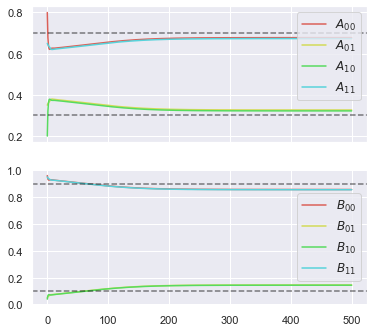

In [141]:

fig, ax = plt.subplots(2, 1, figsize=(6, 5.5), sharex=True)

ax[0].plot([A[0, 0] for A in A_tracker], label=r"$A_{00}$")
ax[0].plot([A[0, 1] for A in A_tracker], label=r"$A_{01}$")
ax[0].plot([A[1, 0] for A in A_tracker], label=r"$A_{10}$")
ax[0].plot([A[1, 1] for A in A_tracker], label=r"$A_{11}$")

ax[1].plot([B[0, 0] for B in B_tracker], label=r"$B_{00}$")
ax[1].plot([B[0, 1] for B in B_tracker], label=r"$B_{01}$")
ax[1].plot([B[1, 0] for B in B_tracker], label=r"$B_{10}$")
ax[1].plot([B[1, 1] for B in B_tracker], label=r"$B_{11}$")

ax[0].axhline(hmm.A[0,0], linestyle='--', alpha=0.5, color='k')
ax[0].axhline(hmm.A[0,1], linestyle='--', alpha=0.5, color='k')
ax[1].axhline(hmm.B[0,0], linestyle='--', alpha=0.5, color='k')
ax[1].axhline(hmm.B[0,1], linestyle='--', alpha=0.5, color='k')

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

In [142]:
# Looks like it does, here the final (although potentially not fully converged yet) values are

A_final, B_final = A_tracker[-1], B_tracker[-1]

In [143]:
A_final, B_final

(array([[0.67786595, 0.32661822],
        [0.32213405, 0.67338178]]),
 array([[0.85629326, 0.14527562],
        [0.14370674, 0.85472438]]))

In [144]:
hmm.A, hmm.B

(array([[0.7, 0.3],
        [0.3, 0.7]]),
 array([[0.9, 0.1],
        [0.1, 0.9]]))

In [145]:
# Just for fun, lets run EVEN longer
A_hat = A_init
B_hat = B_init

A_tracker = [A_hat]
B_tracker = [B_hat]

for _ in range(5000):
    A_hat, B_hat = baum_welch_step(A_hat, B_hat, obs_ts, analyzer)
    A_tracker.append(A_hat)
    B_tracker.append(B_hat)

In [146]:
A_tracker[-1], B_tracker[-1]

(array([[0.67787021, 0.32661395],
        [0.32212979, 0.67338605]]),
 array([[0.85628831, 0.1452806 ],
        [0.14371169, 0.8547194 ]]))